In [18]:
#Расчёт пластинчатого ТО (волны-sandia)
import matplotlib.pyplot as pt
import numpy as n
from CoolProp.CoolProp import PropsSI as p
from scipy.optimize import root
import math as m

#Исходные данные:
G1 = 244.36
T11 = 71.57
T12 = 62.52

G2 = 244.36
T21 = 37.52



P11=5729300
P21=17000000
P12 = P11
P22 = P21

##############################################
CO2  = 'REFPROP::CO2'
H2O  = 'REFPROP::WATER'
O2   = 'REFPROP::Oxygen'
MIX1 =  'REFPROP::CO2[0.931]&WATER[0.069]'
MIX2 =  'REFPROP::CO2[0.993]&WATER[0.007]'
MIX05 =  'REFPROP::CO2[0.95]&WATER[0.05]' #Для транспортный свойств


H11  = p('H','T', T11+273.15, 'P', P11, CO2)
H12  = p('H','T', T12+273.15, 'P', P11, CO2)
H21  = p('H','T', T21+273.15, 'P', P21, CO2)

#Разбиение по энтальпии:
s    = 100 #Кол-во шагов
step = (H11-H12)/(s) 

#Нулевые массивы:
t1   = n.zeros(s+1)
t2   = n.zeros(s+1)
Q    = n.zeros(s+1)

#Противоток:
h11 = H11
i=0
for i in range(s+1):
    t1[i] = p('T','H', h11, 'P', P11, CO2)-273.15 
    h12 = h11 - step
    dQ = G1 * (h11-h12)
    if i < s:
        Q[i+1]=Q[i]+dQ
    h11 = h12
h21 = H21
i=0
for i in range(s+1):
    t2[s-i] = p('T','H', h21, 'P', P21, CO2)-273.15  
    h22 = h21+((Q[s-i]-Q[s-i-1])/G2)
    h21 = h22
DT=t1-t2
##############################################

t1av = n.zeros(s)
t2av = n.zeros(s)
ro1 = n.zeros(s)
ro2 = n.zeros(s)
nu1 = n.zeros(s)
nu2 = n.zeros(s)
lambda1 = n.zeros(s)
lambda2 = n.zeros(s)
Pr1 = n.zeros(s)
Pr2 = n.zeros(s)
DTav = n.zeros(s)
w1 = n.zeros(s)
w2= n.zeros(s)
Re1= n.zeros(s)
Re2= n.zeros(s)
Nu1= n.zeros(s)
Nu2= n.zeros(s)
f1= n.zeros(s)
f2= n.zeros(s)
alpha1= n.zeros(s)
alpha2= n.zeros(s)
K= n.zeros(s)
F= n.zeros(s+1)
L= n.zeros(s+1)
P1= n.zeros(s+1)
P2= n.zeros(s+1)


ddP1     =n.zeros(10000)
ddP2     =n.zeros(10000)
ddP4     =n.zeros(10000)
ddP6     =n.zeros(10000)
ddP8     =n.zeros(10000)
ddP10    =n.zeros(10000)




Vv     =n.zeros(10000000)
DdP1   =n.zeros(10000000)
DdP2   =n.zeros(10000000)
Ff     =n.zeros(10000000)
Ll     =n.zeros(10000000)
Nnsumm =n.zeros(10000000)

#Для каждого участка:
for i in range(s):
    #Свойства
    t1av[i]   =(t1[i]+t1[i+1])/2
    t2av[i]   =(t2[i]+t2[i+1])/2
    ro1[i]    =p('D','T', t1av[i]+273.15, 'P', P11, CO2)
    ro2[i]    =p('D','T', t2av[i]+273.15, 'P', P21, CO2)
    nu1[i]    =p('V','T', t1av[i]+273.15, 'P', P11, CO2)/ro1[i]
    nu2[i]    =p('V','T', t2av[i]+273.15, 'P', P21, CO2)/ro2[i]
    lambda1[i]=p('L','T', t1av[i]+273.15, 'P', P11, CO2)
    lambda2[i]=p('L','T', t2av[i]+273.15, 'P', P21, CO2)
    Pr1[i]    =p('PRANDTL','T', t1av[i]+273.15, 'P', P11, CO2)
    Pr2[i]    =p('PRANDTL','T', t2av[i]+273.15, 'P', P21, CO2)
    DTav[i]   =t1av[i]-t2av[i]
#От выпадающих Pr:
for i in range(1,s):
    if abs(Pr1[i]-Pr1[i-1])>Pr1[i-1]:
        Pr1[i]=p('PRANDTL','T', t1[i]+273.15, 'P', P11, CO2)
    if abs(Pr2[i]-Pr2[i-1])>Pr2[i-1]:
        Pr2[i]=p('PRANDTL','T', t2[i]+273.15, 'P', P21, CO2)

#Геометрия
delta = 0.0015      #толщина металла
hc = 0.00094        #высота канала
wpl = 1             #ширина пластины
wc = wpl/1.254      #ширина проходного сечения
fprohc = wc*hc      #проходное сечение 1 пластины
dh =0.00109         #характерный размер
hpl = delta         #высота пластины
lambdaw = 20        #теплопроводность металла

#Геометрия "выхода":
roout1 = p('D','T', t1[s]+273.15, 'P', P11, CO2)
roout2 = p('D','T', t2[s]+273.15, 'P', P21, CO2)


j=0
wout1go = 0.1
wout1stop = 1000
wout1step = 0.1
for wout1 in n.arange(wout1go,wout1stop,wout1step):
    Fproh1 = G1/(roout1*wout1)
    Npl1 = m.ceil(Fproh1/fprohc)
    Npl2 = m.ceil(Npl1/2)
    Nsumm = Npl1+Npl2
    Fproh2 = Npl2*fprohc
    Fl = ((Npl1+Npl2)/2)*(1.905)
    
    
    P1[0]=P11
    P2[0]=P21
    #Для каждого участка:
    for i in range(s):
        w1[i] = G1/(ro1[i]*Fproh1)
        w2[i] = G2/(ro2[i]*Fproh2)
        Re1[i]=w1[i]*dh/nu1[i]
        Re2[i]=w2[i]*dh/nu2[i]
        Nu1[i] = 0.1740*Re1[i]**0.593*Pr1[i]**0.430
        Nu2[i] = 0.1740*Re2[i]**0.593*Pr2[i]**0.430
        f1[i] = 0.4545*Re1[i]**-0.405
        f2[i]= 0.4545*Re2[i]**-0.405
        alpha1[i] = Nu1[i]*lambda1[i]/dh
        alpha2[i] = Nu2[i]*lambda2[i]/dh
        K[i] = 1/((1/alpha1[i])+(delta/lambdaw)+(1/alpha2[i]))
        dF = (Q[i+1]-Q[i])/(K[i]*DTav[i])
        dL = dF/Fl
        if i < s:
            F[i+1]=F[i]+dF
        if i < s:
            L[i+1]=L[i]+dL
        dP1 = f1[i]*dL/dh*ro1[i]*w1[i]**2/2
        dP2 = f2[i]*dL/dh*ro2[i]*w2[i]**2/2
        if i < s:
            P1[i+1]=P1[i]-dP1
            P2[i+1]=P2[i]-dP2
        DP1 = P1[0]-P1[s]
        DP2 = P2[0]-P2[s]
    Vv[j] = Nsumm*hpl*L[s]*wpl
    
    if round(DP1/1000000000000)==round(0.01*P11/1000000000000):     #0.01 - процент от входного 
        ddP1[j] = DP1
    if round(DP1/1000000000000)==round(0.02*P11/1000000000000):     #0.02 - процент от входного 
        ddP2[j] = DP1
    if round(DP1/1000000000000)==round(0.04*P11/1000000000000):     #0.04 - процент от входного 
        ddP4[j] = DP1
    if round(DP1/1000000000000)==round(0.06*P11/1000000000000):     #0.06 - процент от входного 
        ddP6[j] = DP1
    if round(DP1/1000000000000)==round(0.08*P11/1000000000000):     #0.08 - процент от входного 
        ddP8[j] = DP1
    if round(DP1/1000000000000)==round(0.1*P11/1000000000000):     #0.1 - процент от входного 
        ddP10[j] = DP1    
    
    DdP1[j]   = DP1
    DdP2[j]   = DP2
    Ff[j]     = F[s]
    Ll[j]     = L[s]
    Nnsumm[j] = Nsumm
    j=j+1
    
    if DP1>0.15*P11:
        break;
imax=j
num = int((wout1-wout1go)/wout1step)


dP1p = [10**5 for i in range(imax)]
dP2p = [10**5 for i in range(imax)]
dP4p = [10**5 for i in range(imax)]
dP6p = [10**5 for i in range(imax)]
dP8p = [10**5 for i in range(imax)]
dP10p = [10**5 for i in range(imax)]

for i in range(imax):
    dP1p[i] = abs(0.01*P11 - ddP1[i])
j = n.argmin(dP1p)
print('1%', DdP1[j],DdP2[j],Ff[j],Nnsumm[j],Ll[j])

for i in range(imax):
    dP2p[i] = abs(0.02*P11 - ddP2[i])
j = n.argmin(dP2p)
print('2%', DdP1[j],DdP2[j],Ff[j],Nnsumm[j],Ll[j])

for i in range(imax):
    dP4p[i] = abs(0.04*P11 - ddP4[i])
j = n.argmin(dP4p)
print('4%', DdP1[j],DdP2[j],Ff[j],Nnsumm[j],Ll[j])

for i in range(imax):
    dP6p[i] = abs(0.06*P11 - ddP6[i])
j = n.argmin(dP6p)
print('6%', DdP1[j],DdP2[j],Ff[j],Nnsumm[j],Ll[j])

for i in range(imax):
    dP8p[i] = abs(0.08*P11 - ddP8[i])
j = n.argmin(dP8p)
print('8%', DdP1[j],DdP2[j],Ff[j],Nnsumm[j],Ll[j])

for i in range(imax):
    dP10p[i] = abs(0.1*P11 - ddP10[i])
j = n.argmin(dP10p)
print('10%', DdP1[j],DdP2[j],Ff[j],Nnsumm[j],Ll[j]) #высота = Nsumm*hpl, ширина =1м
print(' ')

1% 57210.78065409884 40927.63328699395 30.993543211744672 119.0 0.27343826032108937
2% 113877.48956401274 81511.52478588372 27.01998994812283 87.0 0.3260625691389607
4% 229031.06501025334 165700.85931441933 23.76990015634992 63.0 0.39611548816981074
6% 343758.98713473417 234920.18704250827 22.170640472041367 53.0 0.43917477288251106
8% 458195.251501061 304469.7343142014 21.1171753095661 47.0 0.47170771898288044
10% 572602.8263582801 406289.75129356235 20.350818746657968 42.0 0.508706880306411
 


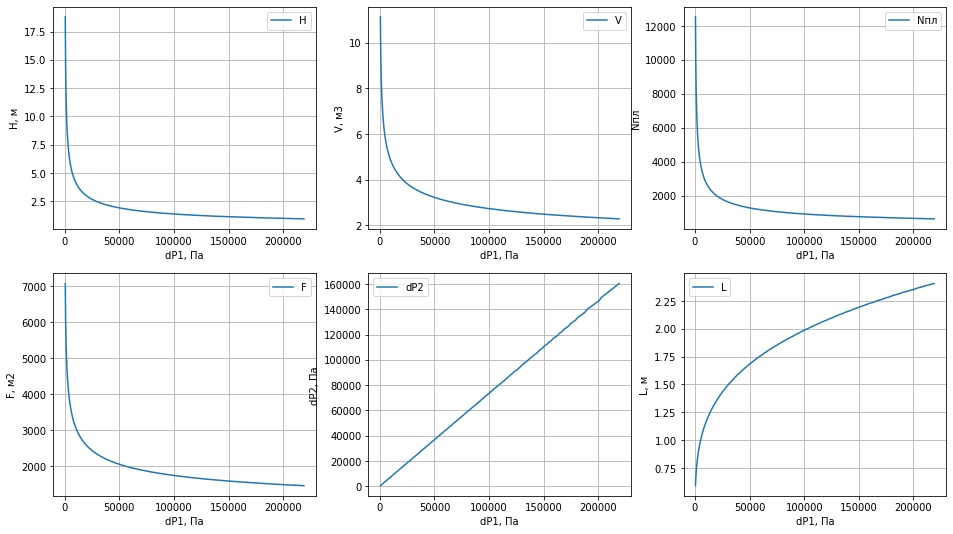

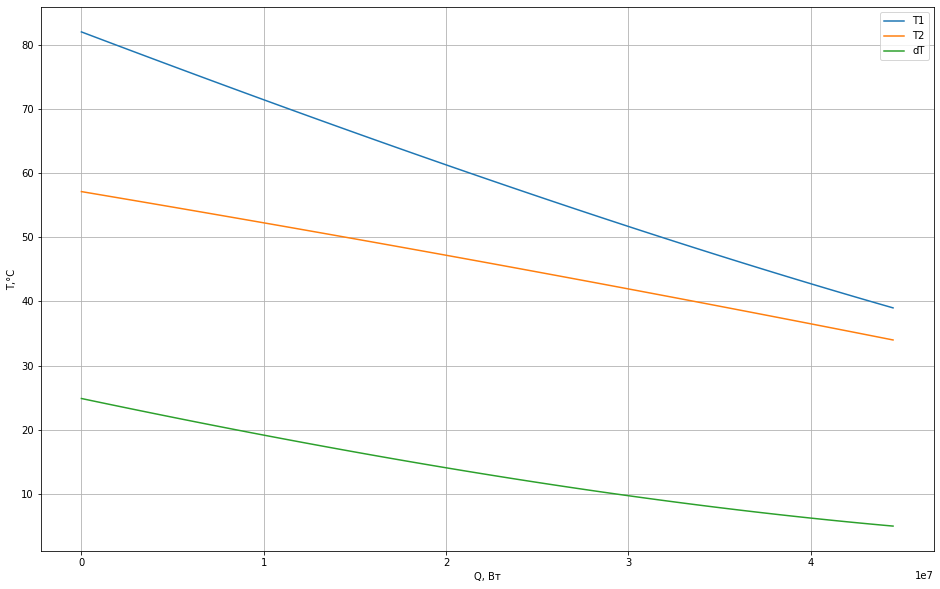

In [3]:
pt.figure(figsize=(16, 9))
x  = [DdP1[i] for i in range(num)]  
y1 = [Ll[i] for i in (range(num))]
pt.subplot(236)
pt.plot(x, y1)
pt.grid(True)
pt.legend(['L'])
pt.xlabel('dP1, Па')
pt.ylabel('L, м')

x  = [DdP1[i] for i in range(num)]  
y1 = [Nnsumm[i]*hpl for i in (range(num))]
pt.subplot(231)
pt.plot(x, y1)
pt.grid(True)
pt.legend(['H'])
pt.xlabel('dP1, Па')
pt.ylabel('H, м')

x  = [DdP1[i] for i in range(num)]  
y1 = [Vv[i] for i in (range(num))]
pt.subplot(232)
pt.plot(x, y1)
pt.grid(True)
pt.legend(['V'])
pt.xlabel('dP1, Па')
pt.ylabel('V, м3')

x  = [DdP1[i] for i in range(num)]  
y1 = [Nnsumm[i] for i in (range(num))]
pt.subplot(233)
pt.plot(x, y1)
pt.grid(True)
pt.legend(['Nпл'])
pt.xlabel('dP1, Па')
pt.ylabel('Nпл')

x  = [DdP1[i] for i in range(num)]  
y1 = [Ff[i] for i in (range(num))]
pt.subplot(234)
pt.plot(x, y1)
pt.grid(True)
pt.legend(['F'])
pt.xlabel('dP1, Па')
pt.ylabel('F, м2')

x  = [DdP1[i] for i in range(num)]  
y1 = [DdP2[i] for i in (range(num))]
pt.subplot(235)
pt.plot(x, y1)
pt.grid(True)
pt.legend(['dP2'])
pt.xlabel('dP1, Па')
pt.ylabel('dP2, Па')
pt.show()

x  = [Q[i] for i in range(s+1)]  
y1 = [t1[i] for i in (range(s+1))]
y2 = [t2[i] for i in (range(s+1))]
y3 = [DT[i] for i in (range(s+1))]
pt.figure(figsize=(16, 10))
pt.plot(x, y1,x, y2,x,y3)
pt.grid(True)
pt.legend(['T1','T2','dT'])
pt.ylabel('T,°C')
pt.xlabel('Q, Вт')
pt.show()